<a href="https://colab.research.google.com/github/AndreyBarTF/turbines_autumn_2022-Homework/blob/Kursach/%D0%9F%D1%83%D0%BD%D0%BA%D1%82_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   ФИО Барбашин Андрей Алексеевич
*   Группа ТФэ-01-20
*   Тлеграмм @QwertyAlexx

In [1]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114282 sha256=1bae72eb4d3714870e7dfd06462bbdd481b2637043e957582099f204ad546a5f
  Stored in directory: /root/.cache/pip/wheels/54/ba/11/fdea0d216e8fb4c2e8e112cd6f9032ec3ff199b073973e1960
Successfully built iapws


# Вариант №1
Дано:
* Тип турбины: К-800-23,5 ЛМЗ;
* P0 = 25 МПа; t0 = 560 C; Pпп = 3,63 МПа; tпп = 565 С; Pк = 3,5 кПа; 
tпв = 269 C; Nэ = 830 МВт; z = 9 шт; dр.с. = 0,9-1,1 м; n = 50 (1/c); H0 = 105 кДж/кг












1. Построить процесс расширения пара в турбине. Определение расходов пара на 
входе в турбину (G0) и в конденсатор (Gк).

0.6972895391608839
Массовый расход в турбину на входе 646.008
Массовый расход в конденсатор: 432.268


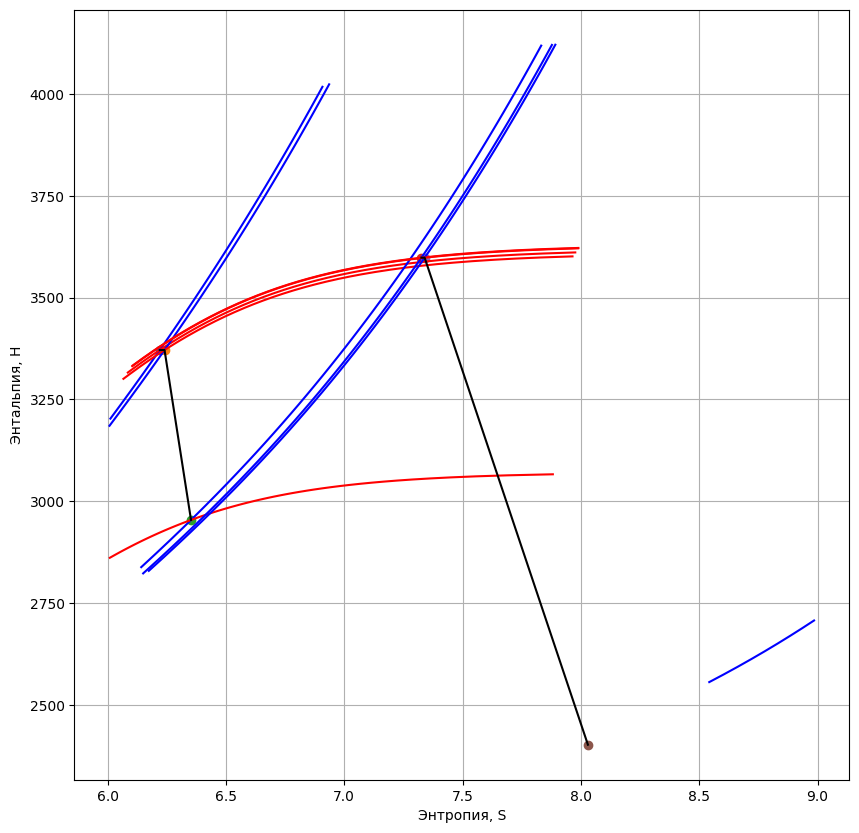

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import iapws
from iapws import IAPWS97 as gas

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

#Исходные данные
#Тип турбины К-800-23,5 ЛМЗ

p_0 = 25 * MPa #Начальное давление
t_0 = 560 #Начальная температура
p_middle = 3.62 * MPa #Давление промперегрева
t_middle = 565 #Температура промперегрева
p_k = 3.5 * kPa #Давление в конденсаторе
t_feed_water = 269 #Температура питательной воды
electrical_power = 830 * (10 ** 6) #Электричесская мощность
z = 9 #Число отборов шт.
avg_diameter = 0.9 # dр.с. = 0,9 - 1,1
rotation_speed = 50 #n
H_0 = 105
p_feed_water = 1.35 * p_0 #Давление питательной воды

#КПД
internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99

#Потери давления
delta_p0 = 0.05 * p_0
delta_p_middle = 0.1 * p_middle
delta_p_1 = 0.03 * p_middle


real_p0 = p_0 - delta_p0
real_p1t = p_middle + delta_p_middle
real_p_middle = p_middle - delta_p_1

def get_points():
  _point_0 = gas(P = p_0 * unit, T=to_kelvin(t_0))
  point_0 = gas(P=real_p0 * unit, h=_point_0.h)
  point_1t = gas(P=real_p1t * unit, s=_point_0.s)

  hp_heat_drop = (_point_0.h - point_1t.h) * internal_efficiency
  h_1 = point_0.h - hp_heat_drop
  point_1 = gas(P=real_p1t * unit, h=h_1)

  _point_middle = gas(P=p_middle * unit, T=to_kelvin(t_middle))
  point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)
  point_2t = gas(P=p_k * unit, s=_point_middle.s)

  lp_heat_drop = (_point_middle.h - point_2t.h) * internal_efficiency
  h_2 = point_middle.h - lp_heat_drop
  point_2 = gas(P=p_k * unit, h=h_2)
  point_k_water = gas(P=p_k * unit, x=0)
  point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))
  return _point_0, point_0, point_1t, hp_heat_drop, point_1, _point_middle, point_middle, lp_heat_drop, point_2, point_k_water, point_feed_water

_point_0, point_0, point_1t, hp_heat_drop, point_1, _point_middle, point_middle, lp_heat_drop, point_2, point_k_water, point_feed_water = get_points()

def get_ksi(point_0, point_1t, _point_middle, point_middle, point_2, point_k_water, point_feed_water):
  numenator_without = point_2.T * (_point_middle.s - point_k_water.s)
  denumenator_without = (point_0.h - point_1t.h) + (point_middle.h - point_k_water.h)
  without_part = 1 - (numenator_without / denumenator_without)

  numenator_infinity = point_2.T * (_point_middle.s - point_feed_water.s)
  denumenator_infinity = (point_0.h - point_1t.h) + (point_middle.h - point_feed_water.h)
  infinity_part = 1 - (numenator_infinity / denumenator_infinity)

  ksi_infinity = 1 - (without_part / infinity_part)
  coeff = (point_feed_water.T - point_2.T) / (to_kelvin(374.2) - point_2.T)
  print(coeff)
  ksi = 0.83 * ksi_infinity
  return ksi

ksi = get_ksi(point_0, point_1t, _point_middle, point_middle, point_2, point_k_water, point_feed_water)

#КПД
def get_eff(hp_heat_drop, lp_heat_drop, point_middle, point_k_water, point_feed_water, ksi, point_0, point_1):
  eff_num = hp_heat_drop + lp_heat_drop
  eff_denum = hp_heat_drop + (point_middle.h - point_k_water.h)

  efficiency = (eff_num / eff_denum) * (1 / (1 - ksi))

  estimated_heat_drop = efficiency * ((point_0.h - point_feed_water.h) + (point_middle.h - point_1.h))
  return efficiency, estimated_heat_drop

#Массовый расход в турбину на входе
def get_inlet_mass_flow(estimated_heat_drop):
  inlet_mass_flow = electrical_power / (estimated_heat_drop * 1000 * mechanical_efficiency * generator_efficiency)
  return inlet_mass_flow

#Массовый расход в конденсатор
def get_condenser_mass_flow(point_2, point_k_water, efficiency):
  condenser_mass_flow = (electrical_power /((point_2.h - point_k_water.h) * 1000 * mechanical_efficiency * generator_efficiency) * ((1 / efficiency) - 1))
  return condenser_mass_flow

efficiency, estimated_heat_drop = get_eff(hp_heat_drop, lp_heat_drop, point_middle, point_k_water, point_feed_water, ksi, point_0, point_1)
inlet_mass_flow = get_inlet_mass_flow(estimated_heat_drop)
condenser_mass_flow = get_condenser_mass_flow(point_2, point_k_water, efficiency)

print("Массовый расход в турбину на входе", round(inlet_mass_flow, 3))
print("Массовый расход в конденсатор:", round(condenser_mass_flow, 3))

#Построение процесса расширения в турбине 
def get_izobar(point):
  t0 = np.arange(10,800,10)
  t_00 = list(map(to_kelvin,t0))

  points_s = [] 
  points_h = []
  for value in t_00:
    if (gas(P = point.P, T=value).s > 6 and gas(P = point.P, T=value).s < 9):
      points_s.append(gas(P = point.P, T=value).s)
      points_h.append(gas(P = point.P, T=value).h)  
  return points_h, points_s

def multiply1(x):
    return x * 10**6

def get_izoterm(point):
  p_00 = np.arange(0.001,30,0.1)
  p_00 = list(map(multiply1,p_00))

  points_ss = [] 
  points_hh = []
  for value in p_00:
    if (gas(P = value * unit, T=point.T).s > 6 and gas(P = value * unit, T=point.T).s < 8):
      points_ss.append(gas(P = value * unit, T=point.T).s)
      points_hh.append(gas(P = value * unit, T=point.T).h)
  return points_hh, points_ss

fig, ax = plt.subplots(1,1,figsize=(10,10))

def plot_hs(points: list, ax):
  for point in points:
    izobar_h, izobar_s = get_izobar(point)
    izoterm_h, izoterm_s = get_izoterm(point)   
    ax.plot(izobar_s, izobar_h, color="blue")
    ax.plot(izoterm_s, izoterm_h, color="red")
    ax.scatter(point.s, point.h)
    
def plot_process(points, ax):
  ax.plot([point.s for point in  points], [point.h for point in points], color="black")
  

plt.xlabel("Энтропия, S")
plt.ylabel("Энтальпия, H")
plt.grid()
plot_hs([_point_0, point_0, point_1], ax = ax)
plot_hs([_point_middle, point_middle, point_2], ax = ax)
plot_process([_point_0, point_0, point_1], ax = ax)
plot_process([_point_middle, point_middle, point_2], ax = ax)
plt.show()

2. Проведение расчета регулирующей ступени и определение зависимости ηол от 
U/cф. Диапазон варьируемого параметра для дан в задании. Обоснованно 
выбрать вариант исполнения регулирующей ступени для проектирования ЦВД
в рамках заданного диапазона.

In [77]:
import math as m
import numpy as np

#окружная скорость на среднем диаметре u
u = m.pi * avg_diameter * rotation_speed

ro = 0.05 #степень реактивности принять в диапазоне 0,05-0,1
#Изоэнтропийный теплоперепад сопловой решетки по параметрам торможения
Hoc = (1 - ro) * H_0
#Изоэнтропийный теплоперепад в рабочей решетке по статическим параметрам
Hop = H_0 * ro
#Теоретическая энтальпия за сопловой решеткой
h1t = _point_0.h - Hoc
#Теоретическая скорость выхода из сопловых лопаток
c1t = m.sqrt(2 * H_0)
#Скорость звука за сопловой решеткой (теоретическая)
k = 1.380649 * (10 ** -23)
p1 = gas(h = h1t, s = _point_0.s)
v1 = gas(h = h1t, s = _point_0.s)
a1t = m.sqrt(k * p1.T * v1.T)
#Число Маха по скорости c1t
M1t = c1t / a1t
#Выходная площадь сопловой решетки (предварительная) 

2.878312734032866e-09